---
title: Dissecting racial bias in an algorithm used to manage the health of populations
author: Hongsup Shin
date: 2024-03-28
image: Fig 1b.png
description: Amidst the LLM hype, algorithmic bias in a critical domain such as healthcare is continued being overlooked. This algorithm-audit paper found racial bias in a widely used healthcare system and discussed the problem of using a wrong target variable. The paper is a few years old but the message is still relevant, and we discussed what's happened since then.
categories: [paper, ML, ethics, fairness]
format:
  html:
    code-fold: true
---

Fresh out of academia and at my first job, I remember being surprised by the great power I was able to wield as the main data scientist in the team. A few lines of my code could easily have cascading impact on business decisions. And (as is often the case) since management didn't care much about technical details, this power gave me a sense of grave responsibility, which was honestly often terrifying. To this day, this sense is something I try to remind myself of, especially because ML systems are getting more complex and we still have very little accountability for ML. So in a way, every ML practitioner is the first line of defense. And this responsibility is more critical if one is working in an high-impact domain such as healthcare.

These days it feels like ML is all about LLMs and AI assistants. But algorithmic bias is still widespread, and unfortunately it's even more overshadowed by this massive hype. This seminal paper from 2019 identified racial bias in a healthcare algorithm and discussed the problem of label choice bias. I find this paper still relevant because this bias can easily sneak when building datasets and algorithms. Since the paper is a few years old, it will be interesting to discuss what's happened since then. I presented the paper in Mar 2024 in Austin ML Journal Club.

## Paper summary

This is a famous paper in Fair ML field that's cited frequently. One reason is that this is one of the first algorithm audit papers that used a creative approach to dissect an algorithm already used in public. The first author Ziad Obermeyer is an active figure in algorithmic bias specifically in healthcare, and the corresponding author Sendhil Mullainathan is a seminal figure in behavioral economics.

The main message of the paper is simple and straightforward. In a widely used healthcare algorithm, the authors found that given a score generated by a trained algorithm, which predicts how sick a patient is, Black patients were much sicker than the White. By using creative approaches, the authors found that this algorithmic behavior originated from label choice bias. The algorithm used healthcare cost as target, which the ML practitioners considered as a proxy for a patient's sickness. The authors cautioned that seemingly effective proxies for ground truth can cause algorithmic bias.

### Background

The authors discussed the difficulty of empirical investigation on commercially used algorithms because they are considered proprietary, and thus researchers have to work "from the outside". They can come up with creative methods but these can be still limiting because without knowing how the model works, it is difficult to understand how and why. For instance, we need training data, objective function, prediction method, and so on, to have a deeper understanding of an algorithm.

#### High-risk care management system

This study is about a high-risk care management system often used in hospitals to provide care for complex medical needs, which tend to be quite expensive. In essence, hospitals want to prioritize patients so that they can optimize which patients will benefit the most by optimizing resource allocation. For instance, early identification of a high risk patient can reduce expensive cost later, like an ER visit. The authors said healthy care systems rely on algorithms *extensively* for this type of care management. This type of algorithm actually has many analogies, and an algorithm like this is often called as a risk assessment tool, which is also used in finance, criminal justice, and so on. 

#### "Who will benefit the most?"

The authors emphasized that this is a difficult *causal inference* problem. We need to estimate individual treatment effects after the resources are allocated. The underlying assumption is "those with the greatest needs will benefit the most," and thus we are setting *future health care needs* as main target. 

### The algorithm

For this study, the authors had a unique advantage to have access to training data, objective function, and prediction. This is mainly due to that the first author worked at the hospital which used the algorithm and he had access.

The data are from a large academic hospital, collected between 2013 and 2015. The authors focused on the white vs. black relationship to examine racial bias. There were about 6k black patients and 40k white patients. For the algorithm, **total medical expenditure** ($C$) is used as target variable. The input feature data are collected from insurance claim data, which includes demographics, insurance type, ICD-9 (international classification of diseases code), medications, medical encounters such as surgery or radiology, and so on. The authors shared the code and data [here](https://gitlab.com/labsysmed/dissecting-bias/-/tree/master) and we can take a look at the data ourselves.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'
import seaborn as sns

In [8]:
data = pd.read_csv("https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv")
data.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


Note that the risk score ($R$, `risk_score_t`) and the predicted cost ($C$, `cost_t`) are not the same. **We do NOT know how the risk score is calculated based on the predicted score.** 

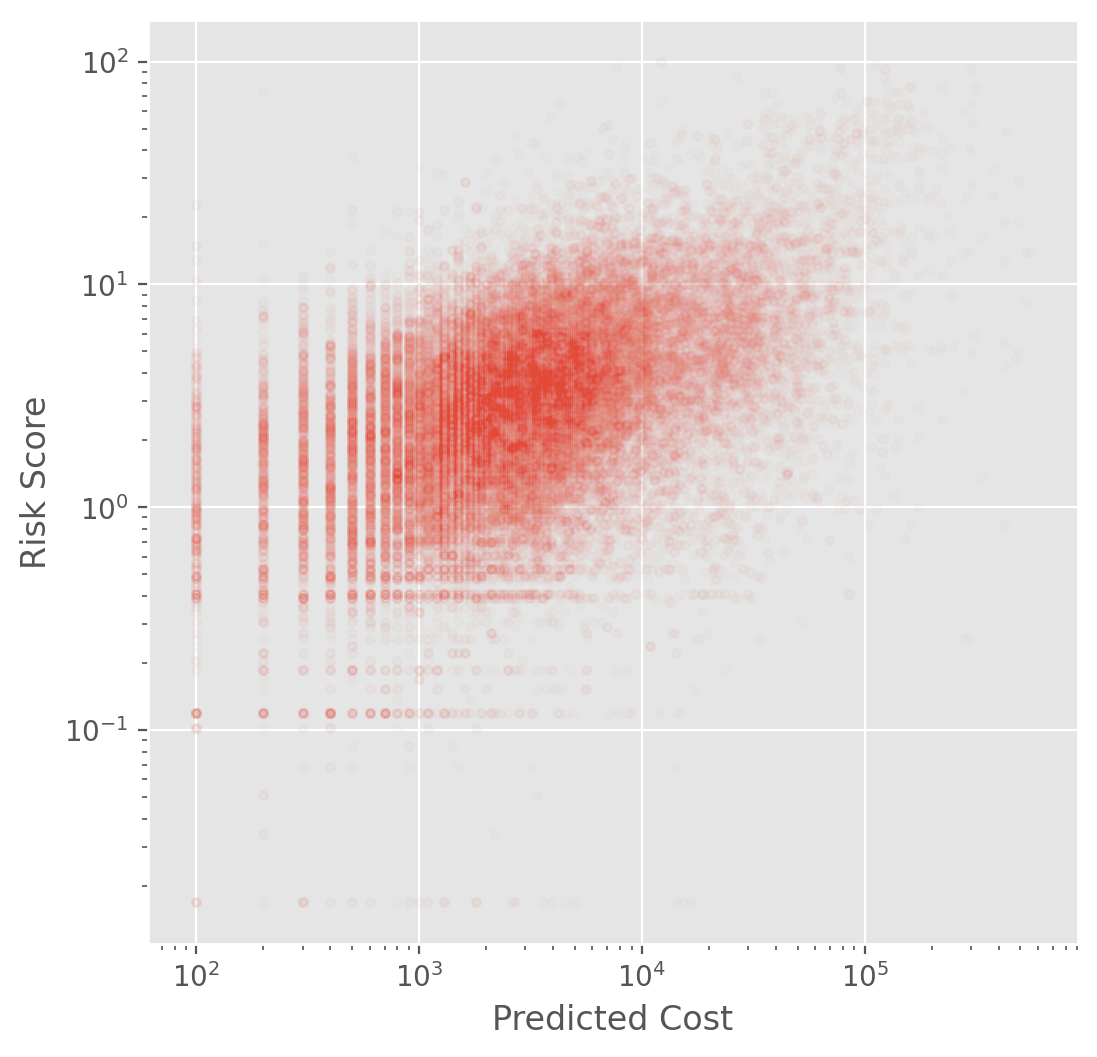

In [3]:
plt.figure(figsize=(6, 6))
plt.plot(data['cost_t'], data['risk_score_t'], '.', alpha=0.01)
plt.loglog()
plt.axis('equal')
plt.xlabel('Predicted Cost')
plt.ylabel('Risk Score')
plt.show()

The algorithm score was generated for each patient during the enrollment period.  After ranking this prediction scores from a group, the top 3% (97th percentile) is automatically flagged as required to be enrolled although this does not guarantee enrollment. The top 45% (55th percentile) is referred to their PCP for further examination.

### The algorithm audit

As a main method, the authors measured the algorithm calibration to assess fairness across different racial groups. This means that the authors focused on parity of how risk score is calibrated across race. Fair result would satisfy
$$E[Y|R, W] = E[Y|R, B]$$

where $Y$ is our main interest, $W$ is the White, $B$ is the Black, and $R$ is the risk score. 

To dissect the algorithm, the authors compared the distribution of $R_{i, t}|H_{i, t}$ and $R_{i, t}|C_{i, t}$ between White and Black patients where
- $R_{i, t}$: risk score given patient $i$ in year $t$ given the input feature $X_{i, t-1}$ from the previous year
- $H_{i, t}$: realized health
- $C_{i, t}$: actual cost 

To measure $H$, the authors used health record data, diagnoses, lab results, and vital sign data. As a main measure of realized health, the authors used comorbidity score, the total number of chronic illnesses over a year, which is a measure of medical complexity. The cost variable $C$ includes insurance claims on utilization, outpatient/ER visit, hospitalization, and general health care costs.

### Using a counterfactual scenario to describe racial bias (Fig. 1B)

Fig. 1A shows mean comorbidity vs. risk score. At a given risk score, Blacks have significantly more illness than Whites. For instance, at the 97th percentile, mean comorbidity score was 4.8 for Black and 3.8 for White. This means that sicker black patients and healthier white patients can have the same score, causing substantial disparities in program screening. The authors designed a counterfactual scenario with no racial bias, and described the severity of the disparity.

**We found it difficult to understand how the authors measured the disparity between the counterfactual and actual**. Fortunately, the code that the authors shared helped us. Here is how this assessment was done in the paper:

1. At a given percentile (e.g., 97th percentile) identify the following:
   - Group "White-above": White patients whose risk score is above the threshold
   - Group "Black-above": Black patients whose risk score is above the threshold
2. If the comorbidity score of the healthiest patient in the White-above group is *lower* than that of the sickest patient in the Black-lower group, remove the healthiest white patients from White-above, and move the sickest Black patient from the Black-lower above the threshold.
3. Repeat this process until patients cannot be moved any more.

The second step can be considered as a White patient who shouldn't be in the enrollment group (above the threshold) giving their spot to the sicker black patient, who was supposed to be in the enrollment group. The authors' original code was written in R but I translated it into python to further investigate this simulation.

In [25]:
def setup(data, default_in_percentile=[95, 97]):
    cohort = data[['race', 'risk_score_t', 'gagne_sum_t']]
    dt = cohort.copy()
    dt['risk_pctile'] = pd.cut(dt['risk_score_t'], bins=np.unique(np.percentile(dt['risk_score_t'], np.arange(0, 101))), include_lowest=True, labels=False)
    
    enroll_stats = np.zeros((len(default_in_percentile), 3))
    enroll_stats = pd.DataFrame(enroll_stats, columns=['black_before', 'black_after', 'ratio'])
    enroll_stats.index = default_in_percentile
    
    return {'dt': dt, 'enroll_stats': enroll_stats}

In [49]:
default_in_percentile = [97]
j = 0

dt = setup(data, default_in_percentile)['dt']
enroll_stats = setup(data, default_in_percentile)['enroll_stats']

prior_enrolled = dt[dt['risk_pctile'] >= default_in_percentile[j]]
prior_w = prior_enrolled[prior_enrolled['race'] == 'white']
prior_b = prior_enrolled[prior_enrolled['race'] == 'black']

upperb = dt[(dt['risk_pctile'] >= default_in_percentile[j]) & (dt['race'] == 'black')]
upperw = dt[(dt['risk_pctile'] >= default_in_percentile[j]) & (dt['race'] == 'white')]
lowerb = dt[(dt['risk_pctile'] < default_in_percentile[j]) & (dt['race'] == 'black')]

upperw = upperw.sort_values('gagne_sum_t')
lowerb = lowerb.sort_values(['risk_score_t', 'gagne_sum_t'], ascending=[False, False])

upperb_actual = upperb.copy()
upperw_actual = upperw.copy()
lowerb_actual = lowerb.copy()

In [50]:
sw = 0
sb = 0
switched_count = 0
switched_w = []
switched_b = []

while sb < lowerb.shape[0]:
    if upperw.iloc[sw]['gagne_sum_t'] < lowerb.iloc[sb]['gagne_sum_t']:
        switched_w.append(upperw.iloc[sw])
        switched_b.append(lowerb.iloc[sb])

        # healthiest white patient is dropped and sickest black patient is added
        upperb = pd.concat([upperb, pd.DataFrame(lowerb.iloc[sb]).T], axis=0)
        upperw = upperw.drop(upperw.index[sw])
        upperw = upperw.sort_values('gagne_sum_t')
        
        sb += 1
        switched_count += 1
    else:
        sb += 1
        switched_count = switched_count

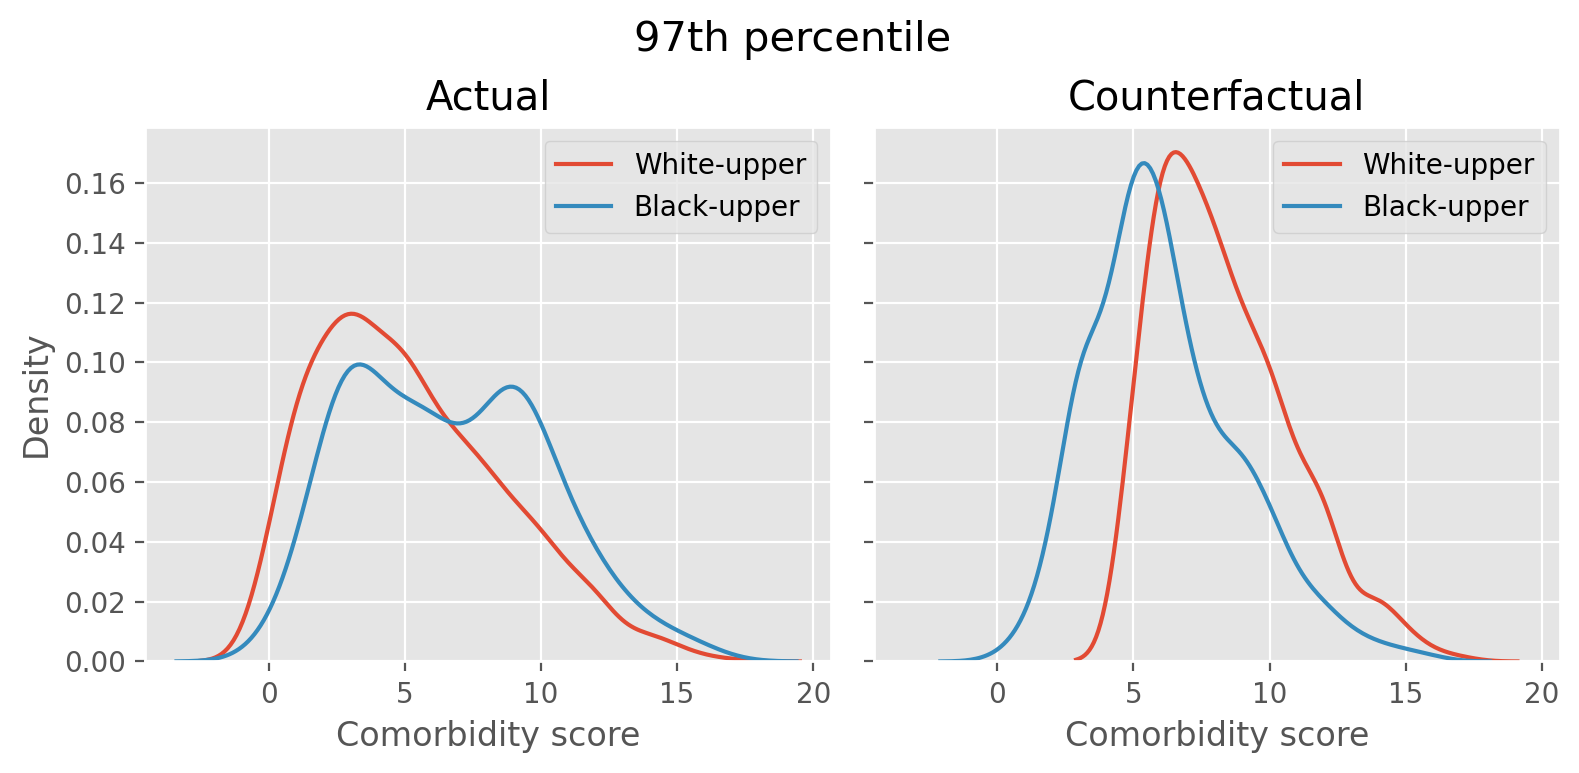

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.kdeplot(upperw_actual['gagne_sum_t'], label='White-upper', ax=axes[0])
sns.kdeplot(upperb_actual['gagne_sum_t'], label='Black-upper', ax=axes[0])
axes[0].set(xlabel='Comorbidity score', title='Actual')
axes[0].legend()

sns.kdeplot(upperw['gagne_sum_t'], label='White-upper', ax=axes[1])
sns.kdeplot(upperb['gagne_sum_t'], label='Black-upper', ax=axes[1])
axes[1].set(xlabel='Comorbidity score', title='Counterfactual')
axes[1].legend()

fig.suptitle('97th percentile', x=0.5, y=0.95, fontsize=15)
fig.tight_layout()

The left figure shows the distribution of comorbidity score of white and black patients who are above the 97th percentile threshold, identified by the algorithm as those who need the high-risk care. The white patient distribution is tilted to the left and the black patient's has more density towards right, indicating that white patients are generally healthier thant the black patients in the above-threshold group. The right figure is after we simulate the counterfactual scenario by swapping the healthiest white patient's slot above the threshold with the sickest black patient below the threshold until the swapping cannot be done any more. The distribution now shows that the two distributions are similar.

### Mechanisms of bias

Based on Fig. 3A, the algorithm calibrates cost (target variable) quite well, meaning this is not a problem of prediction quality. Fig. 3B shows that at a given level of health score, black patients generate lower costs than the White, making the algorithm prioritizing the White patients. Tab. S2 shows that how healthcare cost is spent between the black and white patients vary by categories. For instance, the black patients have higher costs related to ER and dialysis and fewer inpatient surgical and outpatient specialist costs, which also suggest that their healthcare cost occurs when the worst scenario happens (ER visit). The negative values mean black patients spend less money in that category.

![](Tab S2.png)

There are several socio-economic reasons. First, poor patients face substantial barriers to accessing health care, even the insured ones such as geography or transportation, demands from job and child care, and knowledge of reasons to seek care. There is also cost that is directly affected by race. [Taste-based discrimination](https://en.wikipedia.org/wiki/Taste-based_discrimination), employers' prejudice or dislikes in an organizational culture rooted in prohibited grounds can have negative results in hiring minority workers, is one, and the doctor-patient relationship is another. It is known that black patients would take preventive care suggested by black provider more and they also have lower trust in health care system in general due to an incident like Tuskegee study. Doctors also may have different perceptions of black patients regarding such as intelligence, affiliation, or pain tolerance.

### Experiments on label choice and human-AI interaction

The authors then conducted experiments to see alternative label choices other than the total health care cost can result in fairer results. They compared the original model (total cost) against the two alternatives: avoidable cost such as ER visit, and health (comorbidity score). Even though it was not perfect, they found that the algorithms trained on alternative labels produced fairer results.

Finally, the authors examined the interaction between human doctors and the algorithm. The algorithm's risk score suggests a pool of patients candidates to doctors and they make the ultimate decision on the enrollment. The experiment showed that the doctors can "redress" (=correct) algorithm's bias but not by much. This indicates that the racial bias produced by the algorithm can have drastic disparaging effect on healthcare management across different race groups that humans cannot correct completely.

### Working on solutions together

Interestingly, the authors mentioned that they reached out to the manufacturer of the algorithm with their results. Fortunately, they were able to replicate the authors' results on their own and by collaborating with the authors, they were able to reduce the bias by 84%. With this, the authors ended the paper on a hopeful note. They emphasized that algorithmic bias is fixable and this does not necessarily require changes in the algorithm itself.

The paper triggered multiple investigations and stimulated algorithm audit research in the following years. In the same year in 2019, [New York regulators started investing UnitedHealth algorithm for racial bias](https://www.wsj.com/articles/new-york-regulator-probes-unitedhealth-algorithm-for-racial-bias-11572087601) and similarly in [California in 2022](https://oag.ca.gov/news/press-releases/attorney-general-bonta-launches-inquiry-racial-and-ethnic-bias-healthcare). In 2021, [FTC published a guidance document on truth, fairness, and equity in the use of AI in industry](https://www.ftc.gov/business-guidance/blog/2021/04/aiming-truth-fairness-equity-your-companys-use-ai). In 2024, there has been a [Senate Finance Committee Hearing on AI in healthcare](https://www.finance.senate.gov/chairmans-news/wyden-statement-at-finance-committee-hearing-on-ai-in-health-care) as well.

## Journal club discussion

We first had several questions about the care management system described in the paper. The cost categories listed in the paper seemed to include cost for both patients and hospitals and we were not sure whether the cost allocation mattered at all. Some of us were also curious about the actual outcome of the care management system especially for the patients who were enrolled (and potential racial bias of the realized outcome). We also talked about other demographic features that can cause medical bias such as gender and age, and especially their intersectionality.

We agreed that the technical description of the counterfactual scenario was not clear in the paper, and we spent some time understanding how it worked. Similarly, Tab. 2, where the authors created different models with alternative labels and measured the proportion of the high-risk patients identify each model, was a bit confusing to understand, but fortunately, because the authors shared their code for all analyses, we were able to follow eventually.

We then talked about how to satisfy certain criteria during model training. We questioned the feasibility of satisfying multiple criteria (e.g., fairness metric and accuracy) in healthcare where we often have to work with very small data. This problem will get worsened when considering intersectionality, for instance. And the small data problem naturally leads to safety and privacy issues, especially when data contain sensitive information like in healthcare.

We also discussed practical aspects such as how to roll out an algorithm carefully especially when it touches millions of people. Some companies release their models gradually and share training data publicly, but we were wondering whether there were more specific tips on how ML deployment can evolve while having human in the loop, especially those who are impacted by the algorithm. And finally, we agreed that even though it's important to understand how algorithmic bias damages our society and people, we were hopeful that we would like to learn about positive and beneficial use case of ML.